### Importing libraries and stuff


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### Setup and configs

In [2]:
def setup_environment():
    """Checks for GPU and sets memory growth to avoid common CUDA errors."""
    print(f"TensorFlow Version: {tf.__version__}")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU(s) available: {gpus}")
            print("GPU memory growth set.")
        except RuntimeError as e:
            print(f"Error setting up GPU: {e}")
    else:
        print("No GPU found, running on CPU.")

# Configuration parameters
DATASET_DIR = 'datasets/Sapienza University Mobile Palmprint Database(SMPD)'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
# Epochs for training
EPOCHS_FEATURE_EXTRACTION = 3
EPOCHS_FINE_TUNE = 2

### Preprocessing and ROI Extraction


In [3]:
def extract_palm_roi(image, size=(128, 128)):
    """
    Extracts a square Region of Interest (ROI) from the center of the palm.
    This is the most critical step for reliable biometric recognition.
    """
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    hand_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(hand_contour)
    if M["m00"] == 0:
        return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    roi_size = int(min(image.shape[0], image.shape[1]) * 0.4)
    half_size = roi_size // 2

    x1, y1 = max(0, cx - half_size), max(0, cy - half_size)
    x2, y2 = min(image.shape[1], cx + half_size), min(image.shape[0], cy + half_size)

    roi = image[y1:y2, x1:x2]
    if roi.size == 0:
        return None

    return cv2.resize(roi, size, interpolation=cv2.INTER_AREA)

### Data Preparation


In [4]:
def load_and_preprocess_dataset(data_dir, img_size):
    """Loads images, applies ROI extraction, and returns data ready for training."""
    if not os.path.isdir(data_dir):
        print(f"Error: Dataset directory not found at '{data_dir}'")
        print("Please ensure the path is correct and the data is unzipped.")
        return None, None, None

    images, labels = [], []
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    label_map = {name: i for i, name in enumerate(class_names)}

    print(f"Loading data from {len(class_names)} users...")
    for user_id in class_names:
        user_dir = os.path.join(data_dir, user_id)
        for fname in os.listdir(user_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(user_dir, fname)
                img = cv2.imread(img_path)
                roi = extract_palm_roi(img, size=img_size)
                if roi is not None:
                    images.append(roi)
                    labels.append(label_map[user_id])
    
    return np.array(images), np.array(labels), class_names


### Build Model and Transfer Learning

In [5]:
def build_model(input_shape, num_classes):
    """Builds a classification model using MobileNetV2 as a pre-trained base."""
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name='augmentation')

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # ### FIX: Create the model first, then name it for TF 2.10 compatibility ###
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model._name = 'mobilenetv2_base'
    base_model.trainable = False

    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

### Plotting and Inference

In [6]:
def plot_history(history, history_fine):
    """Visualizes the training and validation accuracy/loss."""
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(len(history.history['accuracy']) - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(len(history.history['loss']) - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    
    plt.savefig('training_history.png')
    plt.show()


### Main Functions

TensorFlow Version: 2.10.0
GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU memory growth set.
Loading data from 92 users...

Successfully processed 3677 images.
Data shape: (3677, 128, 128, 3), Labels shape: (3677,), Classes: 92
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_base (Functiona  (None, 4, 4, 1280)       2257984   
 l)                                                    

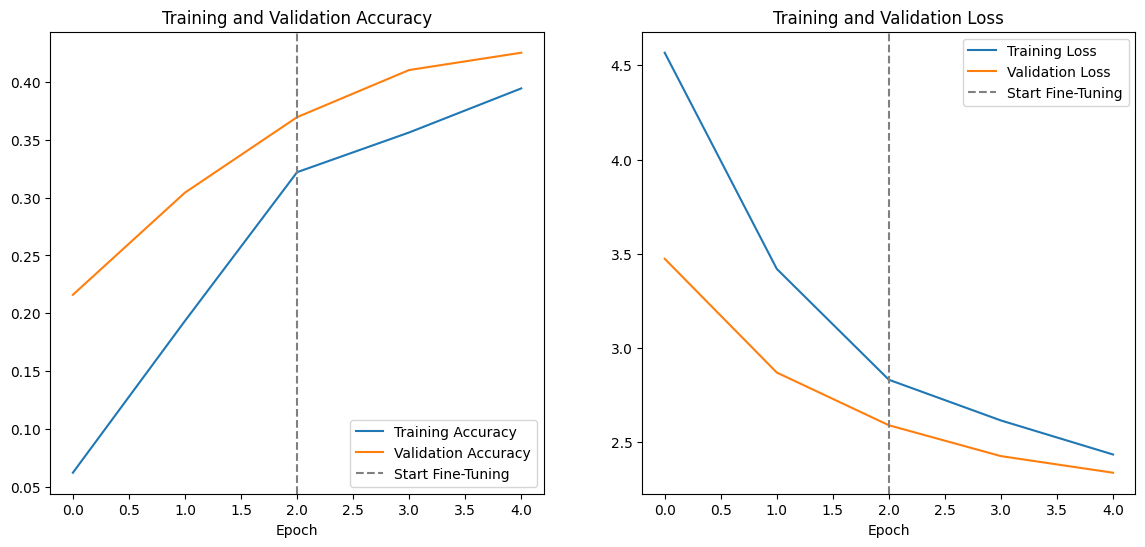

Training complete. Model saved to 'best_palm_model.keras' and history plot saved to 'training_history.png'.


In [7]:
def main():
    """Main function to run the entire pipeline."""
    setup_environment()

    # --- 1. Load Data ---
    X, y, class_names = load_and_preprocess_dataset(DATASET_DIR, img_size=IMG_SIZE)
    if X is None:
        return # Exit if data loading failed

    NUM_CLASSES = len(class_names)
    print(f"\nSuccessfully processed {len(X)} images.")
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}, Classes: {NUM_CLASSES}")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # --- 2. Build Model ---
    model = build_model(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # --- 3. Train Model (Phase 1: Feature Extraction) ---
    print("\n--- Starting Training: Feature Extraction Phase ---")
    callbacks = [
        ModelCheckpoint('best_palm_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
        EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FEATURE_EXTRACTION, callbacks=callbacks)

    # --- 4. Train Model (Phase 2: Fine-Tuning) ---
    print("\n--- Starting Training: Fine-Tuning Phase ---")
    base_model = model.get_layer('mobilenetv2_base')
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history_fine = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_FEATURE_EXTRACTION + EPOCHS_FINE_TUNE,
        initial_epoch=history.epoch[-1] + 1,
        callbacks=callbacks
    )
    
    # --- 5. Evaluate and Save Results ---
    print("\n--- Final Evaluation ---")
    best_model = tf.keras.models.load_model('best_palm_model.keras')
    loss, accuracy = best_model.evaluate(val_ds)
    print(f"Final Model Accuracy on Validation Set: {accuracy * 100:.2f}%")
    plot_history(history, history_fine)
    print("Training complete. Model saved to 'best_palm_model.keras' and history plot saved to 'training_history.png'.")

# This is standard practice for making a Python script executable
if __name__ == "__main__":
    main()
